# Monte Carlo Simulation

This notebook provides a solution to the problem based on the scenario in https://pythonprogramming.net/monte-carlo-simulator-python/, with the following **improvements**:

- Object oriented programming
- Multi-processing

Scenario:


In [1]:
import random
import multiprocessing as mp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from matplotlib import style
style.use("ggplot")
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 7.0)

## Create environment

In [2]:
class Game(object):
    def play(self):
        raise NotImplementedError()

class RollDie(Game):
    """
    Chance of winning: 49/100
    The house maintains a 1% edge
    """
    def play(self):
        outcome = random.random()
        
        if outcome <= 0.51:
            return False
        else:
            return True
        
class Roulette(Game):
    """
    Consider only betting on red/black, even/odd or 1-18/19-36
    There are 36 red and black numbers plus the green numbers 0
    Therefore the chances of winning = 18/37, whereas that of lossing = 19/37
    """
    def play(self):
        outcome = random.randint(0,36)
        
        if outcome <= 18:
            return False
        else:
            return True

In [3]:
class Bettor(object):
    """
    Base Bettor class
    """
    def __init__(self, funds, init_wager_amt, num_wager, game, **kwargs):
        self.funds = list()
        self.wager = list()
        
        self.funds.append(funds)
        self.wager.append(init_wager_amt)
        self.num_wager = num_wager
        self.game = game
        self.line_color = kwargs.get('line_color')
        self.previous_result = 'win'
        self.broke = False if self.funds[-1] > 0 else True
    
    def _bet_cap(self, amount):
        """ Bettor cannot bet more than he has """
        if self.funds[-1] < amount:
            return self.funds[-1]
        else:
            return amount
        
    def _get_next_wager(self):
        """ Specify strategy here """
        raise NotImplementedError()
    
    def bet(self):
        n = 0
        while n <= self.num_wager:
            if self.broke:
                # Not allow to bet if broke
                break
            else:
                current_wager = self._bet_cap(self._get_next_wager())
                self.wager.append(current_wager)
                
                if self.game.play():
                    self.previous_result = 'win'
                else:
                    self.previous_result = 'loss'
                    current_wager = -current_wager

                current_fund = self.funds[-1] + current_wager
                
                if current_fund <= 0:
                    self.broke = True
                    
            self.funds.append(current_fund)
            n += 1
    
    def plot_fund_hist(self):
        plt.plot(range(0, len(self.funds)), self.funds, color=self.line_color)
        plt.ylabel('Fund value')
        plt.xlabel('Number of wagers')
        plt.axhline(0, color = 'r')
        
    def get_pnl(self, as_perc):
        """ PnL at the end of all wagers """
        if as_perc:
            return (self.funds[-1] - self.funds[0]) / self.funds[0]
        else:
            return (self.funds[-1] - self.funds[0])

In [6]:
class BetSimulator(object):
    def __init__(self, sample_size, bettor, n_jobs=10, as_perc=True):
        """
        sample_size : int
            Number of bettors in this simulation
        bettor : tuple
            (bettor name, dict(bettor args))
        """
        self.sample_size = sample_size
        self.bettor = bettor
        self.n_jobs = n_jobs
        self.as_perc = as_perc
        self.stats = dict()
        
    def _run(self):
        bettor = eval(self.bettor[0])(**self.bettor[1])
        bettor.bet()
        return bettor.funds, bettor.wager, bettor.get_pnl(as_perc=self.as_perc), bettor.broke
        
    def run(self):
        pool = mp.Pool(processes=self.n_jobs)
        results = [pool.apply_async(self._run) for n in range(self.sample_size)]
        results = np.array([p.get() for p in results])
        pool.close()
        
        self.stats['funds'] = results[:, 0]
        self.stats['wager'] = results[:, 1]
        self.stats['pnl_mean'] = np.mean(results[:, 2])
        self.stats['pnl_std'] = np.std(results[:, 2])
        self.stats['broke_rate'] = np.sum(results[:, 3]) / self.sample_size
    
    def plot_hist(self, metric, show_zero=False, **kwargs):
        for f in self.stats[metric]:
            plt.plot(range(0, len(f)), f)

        plt.title('Sample size: {}'.format(self.sample_size))
        plt.ylabel(kwargs.get('ylabel'))
        plt.xlabel(kwargs.get('xlabel'))
        if show_zero:
            plt.axhline(0, linestyle='--', color='r', linewidth=4)
        plt.show()

## Simulations parameters

Using a small amount of samples, so that the simulation finishes quickly for demonstration purpose.

Smallest unit is one chip which is $1.

In [119]:
sample_size = int(1e4)  # number of bettors
funds = 1e4  # initial funds
init_wager_amt = 10  # ten chips
num_wager = 2000  # number of times each bettor wages
as_perc = True

## Strategy 1: Simple bettor

A simple bettor always bets on the same amount.

**Analysis**  
- From the calculations below, the broke rate is (almost) zero with 1000 samples.  
- However, a simple bettor on average is slowly losing money in a long run.

In [8]:
class SimpleBettor(Bettor):
    """
    Strategy:  always bets on the same amount (flat bet)
    """        
    def _get_next_wager(self):
        return self.wager[-1]

Broke rate : 0.0
PnL (%): -0.05428600000000036  ±  0.0455324390298


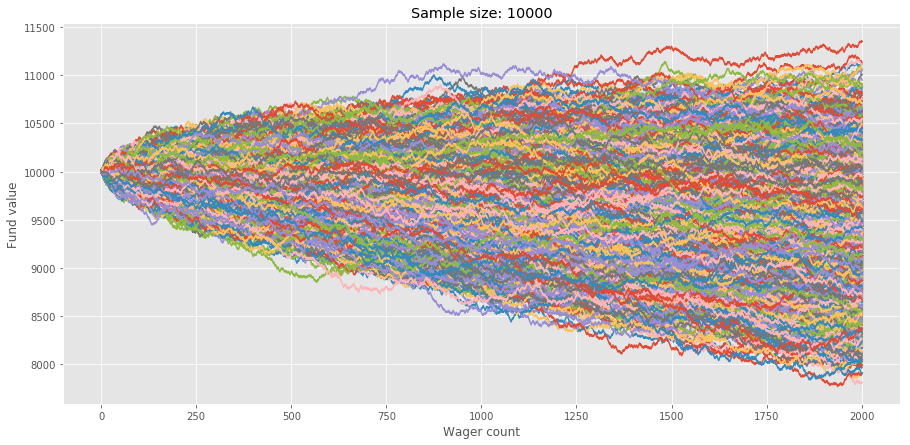

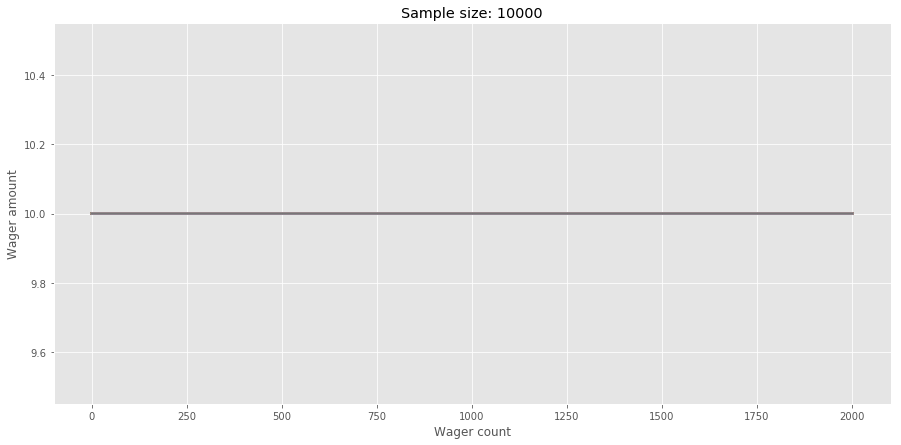

In [10]:
simp_bet_simulator = BetSimulator(sample_size=sample_size, 
                                  bettor=('SimpleBettor',
                                          dict(funds=funds, init_wager_amt=init_wager_amt, 
                                               num_wager=num_wager, game=Roulette())
                                         ),
                                  as_perc=True
                                  )
simp_bet_simulator.run()
print ('Broke rate :', simp_bet_simulator.stats.get('broke_rate'))
print ('PnL {}:'.format('(%)' if as_perc else ''), simp_bet_simulator.stats.get('pnl_mean'), 
       ' ± ', simp_bet_simulator.stats.get('pnl_std'))
simp_bet_simulator.plot_hist(metric='funds', ylabel='Fund value', xlabel='Wager count')
simp_bet_simulator.plot_hist(metric='wager', ylabel='Wager amount', xlabel='Wager count')

## Strategy 2: Martingale bettor

Martingale strategy (https://en.wikipedia.org/wiki/Martingale_(betting_system)): 
- After each loss, double the previous wager amount 
- After each win, return to initial wager amount

**Analysis**  
- Due to the nature of the algorithm, an 'unlucky' bettor with a lossing run will quickly run out of money.  
- It is interesting to see how the wager amounts quickly increase from \$10 to ~\$5000 after ~40 rounds. It is even approaching \$10,000 at the end.  
- As demonstrated below, some bettors' funds rapidly drop to zero in the early rounds.
- High risk and potentially high reward strategy


In [11]:
class MartingaleBettor(Bettor):
    """
    Strategy: Martingale
    """        
    def _get_next_wager(self):
        if self.previous_result == 'win':
            return self.wager[0]
        elif self.previous_result == 'loss':
            return self.wager[-1] * 2

Broke rate : 0.545
PnL (%): -0.19886910000000013  ±  0.909748027294


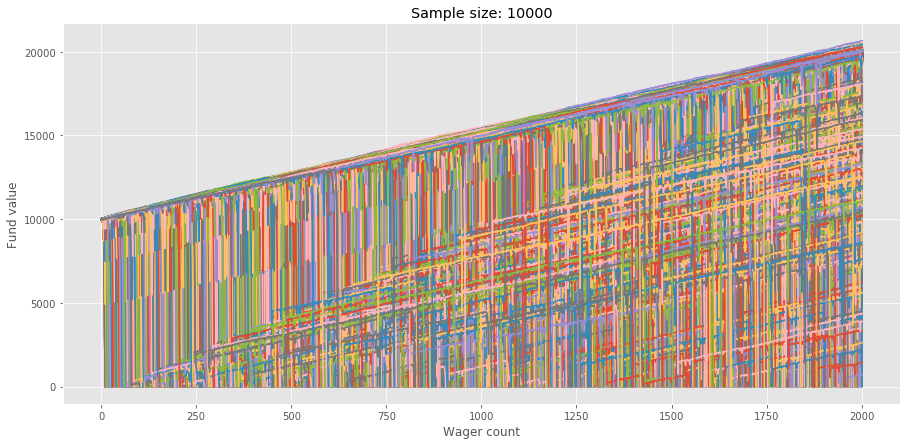

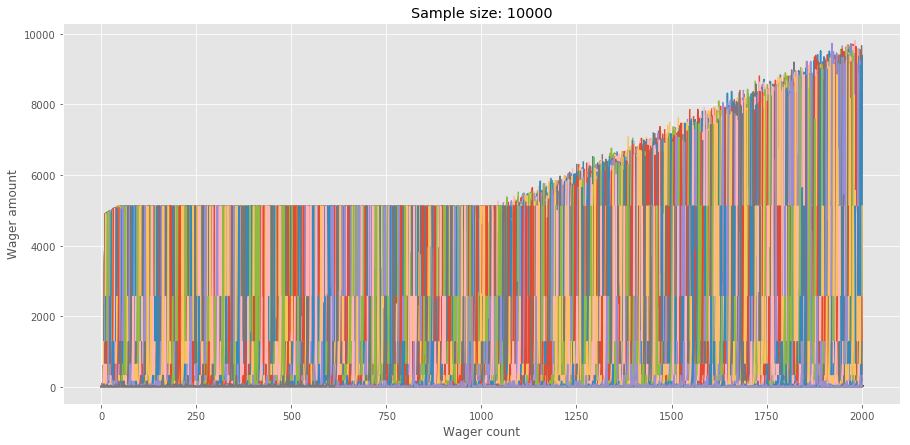

In [12]:
martingale_simulator = BetSimulator(sample_size=sample_size, 
                                    bettor=('MartingaleBettor',
                                            dict(funds=funds, init_wager_amt=init_wager_amt, 
                                                 num_wager=num_wager, game=Roulette())
                                           ),
                                    as_perc=as_perc
                                   )
martingale_simulator.run()
print ('Broke rate :', martingale_simulator.stats.get('broke_rate'))
print ('PnL {}:'.format('(%)' if as_perc else ''), martingale_simulator.stats.get('pnl_mean'), 
       ' ± ', martingale_simulator.stats.get('pnl_std'))
martingale_simulator.plot_hist(metric='funds', ylabel='Fund value', xlabel='Wager count')
martingale_simulator.plot_hist(metric='wager', ylabel='Wager amount', xlabel='Wager count')

## Strategy 3: D'Alembert bettor

D'Alembert strategy:
- After each loss, add one unit to the next bet
- After each win, reduce one unit from the next bet

**Analysis**  
- D'Alember strategy provide a better PnL than Martingale strategy both in terms of broke rate and PnL
- The wager amount vs wager count graph shows that the wager can go up quickly with a losing streak. 
- If the wager amount hits the table limit, then a bettor will not be able to cover previous losses and the game would ultimately be over (although table limit is not implemented here)

In [17]:
class DAlembertBettor(Bettor):
    """
    Strategy: D'Alembert
    """
    def __init__(self, funds, init_wager_amt, num_wager, game, **kwargs):
        self.incr_unit = kwargs.get('incr_unit')
        super(DAlembertBettor, self).__init__(funds, init_wager_amt, num_wager, game, **kwargs)
        
        
    def _get_next_wager(self):
        if len(self.wager) == 1:
            # first round
            return self.wager[0]
        elif self.previous_result == 'win':
            # cannot bet below $1
            return max(self.wager[-1] - self.incr_unit, 1)
        elif self.previous_result == 'loss':
            return self.wager[-1] + self.incr_unit

Broke rate : 0.237
PnL (%): -0.3777020599999995  ±  0.434747541405


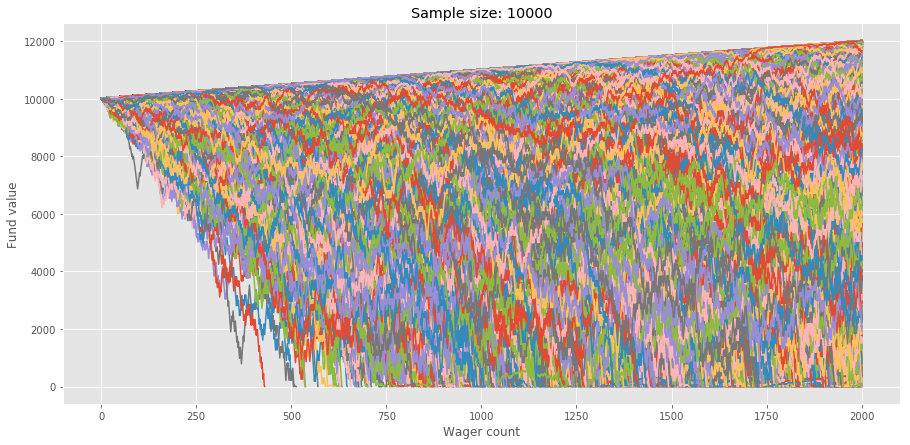

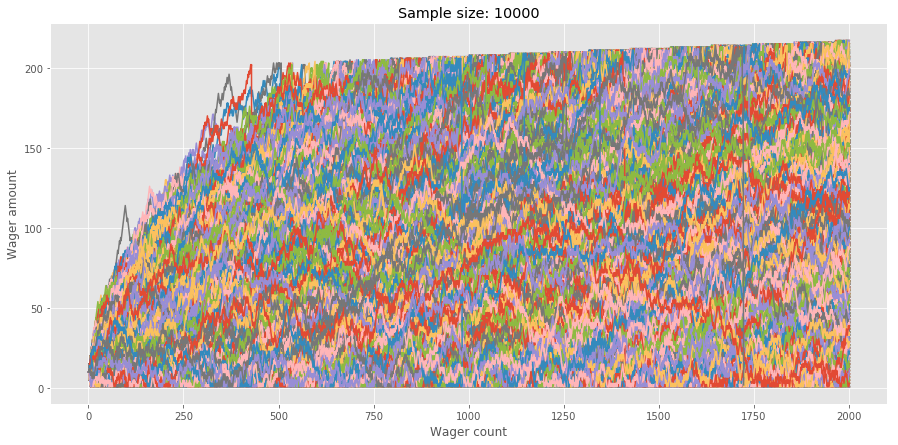

In [19]:
dalembert_simulator = BetSimulator(sample_size=sample_size, 
                                   bettor=('DAlembertBettor',
                                           dict(funds=funds, init_wager_amt=init_wager_amt, 
                                                num_wager=num_wager, game=Roulette(),
                                                incr_unit=2
                                               )
                                          ),
                                   as_perc=as_perc
                                  )
dalembert_simulator.run()
print ('Broke rate :', dalembert_simulator.stats.get('broke_rate'))
print ('PnL {}:'.format('(%)' if as_perc else ''), dalembert_simulator.stats.get('pnl_mean'), 
       ' ± ', dalembert_simulator.stats.get('pnl_std'))
dalembert_simulator.plot_hist(metric='funds', ylabel='Fund value', xlabel='Wager count')
dalembert_simulator.plot_hist(metric='wager', ylabel='Wager amount', xlabel='Wager count')

### Grid Search

**Optimisation objective: ** Maximise average profit by tuning the following variables to find the best settings for a D'Alembert bettor
- initial wager amount as a percentage of available fund
- incremental unit as a percentage if initial wager


Each simulator runs tasks in multi-processes. Here in grid search, multiprocessing is not used because memory will quickly run out otherwise. 

In [127]:
# Choosing the optimal initial wager amount
# 2D grid search
results = list()
verbose = 5
init_wagers_perc = list(map(lambda x: x / 100, range(5, 101, 5))) # 1% - 100% of initial fund
incr_unit = list(range(5, 51, 5))
combinations = itertools.product(init_wagers_perc, incr_unit)

for n, (w, i) in enumerate(combinations): 
    if verbose > 0 and n % 5 == 0:
        print ('w=', w, ', i=', i)
    
    dalembert_simulator = BetSimulator(sample_size=sample_size, 
                                       bettor=('DAlembertBettor',
                                               dict(funds=funds, 
                                                    init_wager_amt=funds * w, 
                                                    num_wager=num_wager, 
                                                    game=Roulette(),
                                                    incr_unit=i
                                                   )
                                              ),
                                       as_perc=as_perc
                                      )
    dalembert_simulator.run()
    results.append((w,
                    i,
                    dalembert_simulator.stats.get('pnl_mean'), 
                    dalembert_simulator.stats.get('pnl_std')
                   )
                  )

w= 0.05 , i= 5
w= 0.05 , i= 30
w= 0.1 , i= 5
w= 0.1 , i= 30
w= 0.15 , i= 5
w= 0.15 , i= 30
w= 0.2 , i= 5
w= 0.2 , i= 30
w= 0.25 , i= 5
w= 0.25 , i= 30
w= 0.3 , i= 5
w= 0.3 , i= 30
w= 0.35 , i= 5
w= 0.35 , i= 30
w= 0.4 , i= 5
w= 0.4 , i= 30
w= 0.45 , i= 5
w= 0.45 , i= 30
w= 0.5 , i= 5
w= 0.5 , i= 30
w= 0.55 , i= 5
w= 0.55 , i= 30
w= 0.6 , i= 5
w= 0.6 , i= 30
w= 0.65 , i= 5
w= 0.65 , i= 30
w= 0.7 , i= 5
w= 0.7 , i= 30
w= 0.75 , i= 5
w= 0.75 , i= 30
w= 0.8 , i= 5
w= 0.8 , i= 30
w= 0.85 , i= 5
w= 0.85 , i= 30
w= 0.9 , i= 5
w= 0.9 , i= 30
w= 0.95 , i= 5
w= 0.95 , i= 30
w= 1.0 , i= 5
w= 1.0 , i= 30


In [128]:
df_results = pd.DataFrame(results, columns=['wager_pct', 'incr_unit', 'pnl_mean', 'pnl_std'])
# df_results.to_csv('wager_pct_vs_incr_unit3.csv')

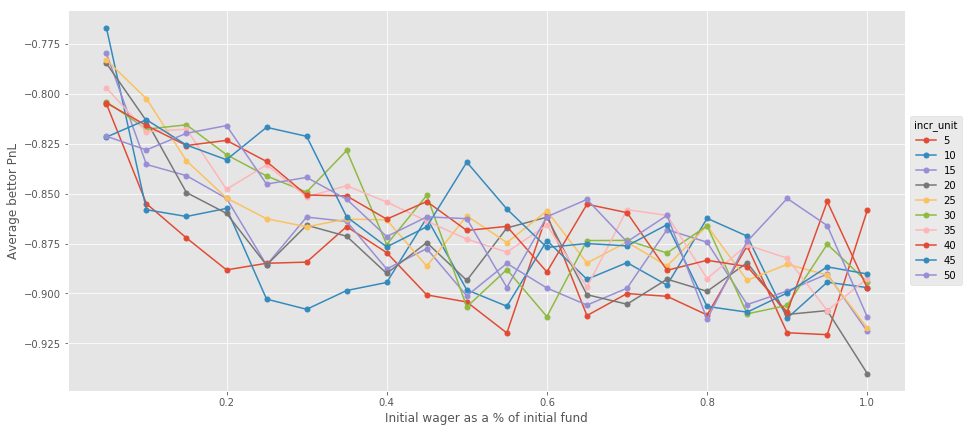

In [139]:
groups = df_results.groupby('incr_unit')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.wager_pct, group.pnl_mean, marker='o', linestyle='-', ms=5, label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='incr_unit')
ax.set_xlabel('Initial wager as a % of initial fund')
ax.set_ylabel('Average bettor PnL')
plt.show()

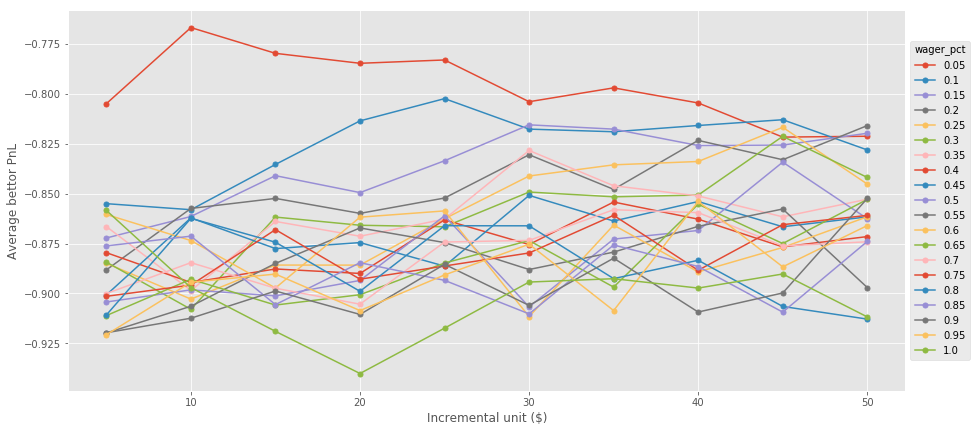

In [140]:
groups = df_results.groupby('wager_pct')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.incr_unit, group.pnl_mean, marker='o', linestyle='-', ms=5, label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='wager_pct')
ax.set_xlabel('Incremental unit ($)')
ax.set_ylabel('Average bettor PnL')
plt.show()

**Analysis**

According the above graphs, to maximise profit it is best not to gamble at all! This is because of the 'edge' the house has against a bettor. In the roulette case, it is the 'green zero'. 

Theoretically, the chances of winning each game = 18/37, whereas that of lossing = 19/37.

The graphs also suggests that average loss can be reduced by decreasing the initial wager amount and the incremental unit compared to the available fund (see top left corner of graphs). 

Even with a 50/50 chance of winning, with such a small initial wager and incremntal unit it will take a very long time to realise any profit.

## Strategy 4: Labouchère system

Description: https://en.wikipedia.org/wiki/Labouchère_system

Work in progress

In [156]:
class LabouchereBettor(Bettor):
    """
    Strategy: Labouchère system
    """
    def __init__(self, funds, sequence, game):
        self.init_funds = funds
        self.funds = funds
        self.sequence = sequence
        self.game = game
        
    def _bet(self, sequence, balance):
        # Won
        if len(sequence) < 1:
            return balance

        # If the sequence is of length 1, the bet is the number in the sequence. Otherwise, it is the first number
        # added to the last number.
        if len(sequence) is 1:
            bet = sequence[0]
        else:
            bet = sequence[0] + sequence[-1]

        # Lost entire round
        if bet > balance:
            return balance

        won = self.game.play()

        if won:
            # Won
            return self._bet(sequence[1:-1], balance+bet)
        else:
            # Lost bet
            return self._bet(sequence+[bet], balance-bet)
        
    def bet(self):
        self.funds = self._bet(self.sequence, self.funds)

    def get_pnl(self, as_perc):
        """ PnL at the end of all wagers """
        if as_perc:
            return (self.funds - self.init_funds) / self.init_funds
        else:
            return (self.funds - self.init_funds)

In [ ]:
# Choosing the optimal initial wager amount
# 2D grid search
results = list()
verbose = 5
target_amt = 1000
sequences = ((200,200,300,300), (100,200,300,400), (50,50,400,50,50,400))
assert all([sum(x) == target_amt for x in sequences])

for n, sequence in enumerate(sequences): 
    if verbose > 0 and n % 5 == 0:
        print ('w=', w, ', i=', i)
    
    labouchere_simulator = BetSimulator(sample_size=sample_size, 
                                        bettor=('LabouchereBettor',
                                                dict(funds=funds, 
                                                     sequence=sequence,
                                                     game=Roulette()
                                                    )
                                               ),
                                        as_perc=as_perc
                                       )
    labouchere_simulator.run()
    results.append((n,
                    labouchere_simulator.stats.get('pnl_mean'), 
                    labouchere_simulator.stats.get('pnl_std')
                   )
                  )